# 생산부품 예측 Regresson pivot
- 목표 : 부품 Part_Number 별로 D일 투입예정 수량(D일 계획) 예측

### 컬럼설명
- Part_Number : 협력기업에서 모기업에 납품해야하는 부품의 식별자 (id)
- CRET_TIME : 특정부품의 발주 수량이 기록된 해당 시각 정보
- D일 X~XH투입 계획 수량 : 당일(D일)의 시각별 발주 및 계획 발주량
- D일 투입 예정 수량 : 당일(D일)의 통합 발주 및 계획 발주량
- D+X일 투입 예정 수량 : 당일(D일)에 기록된 X일 이후의 계획 발주량

### 데이터 특징
- 데이터기간 : 2021-09-11 ~ 2021-11-01

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import *

pd.set_option('display.max_columns', None)

## 1. 전처리

In [2]:
df = pd.read_excel('./data.xls')

# 시간 단위 '일'
df['CRET_TIME'] = df['CRET_TIME'].astype(str)
df['CRET_TIME'] = pd.to_datetime(df['CRET_TIME']).dt.date

In [3]:
# pivot
df_pivot = pd.pivot_table(df,
                          index = 'Part Number',
                          columns = 'CRET_TIME',
                          values = 'D일 투입예정 수량(D일계획)',
                          aggfunc = 'last',
                          fill_value = 0
                         )
df_pivot

CRET_TIME,2021-09-13,2021-09-14,2021-09-15,2021-09-16,2021-09-17,2021-09-18,2021-09-19,2021-09-20,2021-09-21,2021-09-22,2021-09-23,2021-09-24,2021-09-25,2021-09-26,2021-09-27,2021-09-28,2021-09-29,2021-09-30,2021-10-01,2021-10-02,2021-10-03,2021-10-04,2021-10-05,2021-10-06,2021-10-07,2021-10-08,2021-10-09,2021-10-10,2021-10-11,2021-10-12,2021-10-13,2021-10-14,2021-10-15,2021-10-16,2021-10-17,2021-10-18,2021-10-19,2021-10-20,2021-10-21,2021-10-22,2021-10-23,2021-10-24,2021-10-25,2021-10-26,2021-10-27,2021-10-28,2021-10-29,2021-10-30,2021-11-01
Part Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Part 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,5,1,1,1,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Part 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,5,4,9,9,9,9,13,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Part 10,16,16,16,23,158,158,158,158,158,158,158,158,158,158,70,20,29,76,95,0,0,61,112,151,118,73,73,73,73,145,118,108,114,161,161,169,180,195,104,19,19,19,78,155,161,178,156,156,104
Part 100,38,35,40,38,21,21,21,21,21,21,21,21,21,21,6,16,28,48,39,0,0,22,8,2,1,1,1,1,1,0,0,0,0,0,0,5,15,16,23,0,0,0,1,6,27,33,23,23,0
Part 101,0,0,77,78,82,82,82,82,82,82,82,82,82,82,0,95,47,38,33,0,0,30,24,87,108,103,103,103,103,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Part 95,113,209,209,288,276,276,276,276,276,276,276,276,276,276,262,305,309,338,323,305,305,269,311,335,327,236,236,236,236,303,276,352,363,365,365,344,317,209,250,325,325,325,290,249,99,276,264,264,209
Part 96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,1,1,1,1,2,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,6,6,0,0
Part 97,127,32,28,28,28,28,28,28,28,28,28,28,28,28,26,10,23,107,105,0,0,100,118,118,106,99,99,99,99,85,91,99,129,162,162,114,126,127,140,107,107,107,37,7,5,4,3,3,1


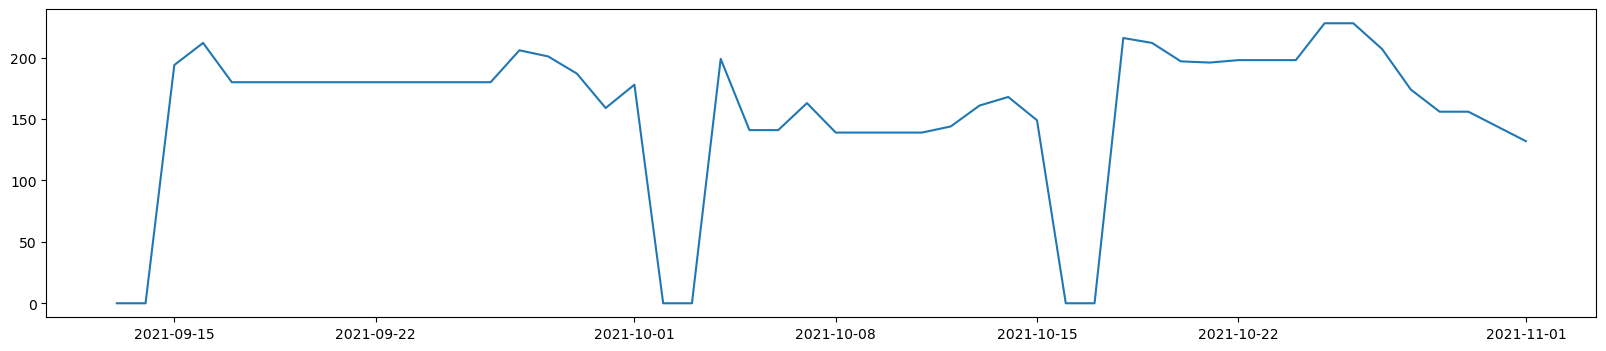

In [26]:
plt.figure(figsize=(20, 4))
plt.plot(df_pivot.loc['Part 26'])

## 3. 모델 학습 및 평가

In [5]:
X = df_pivot.iloc[:, :-1]
y = df_pivot.iloc[:, -1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

print('X_train', X_train.shape, 'y_train', y_train.shape)
print('X_test', X_test.shape, 'y_test', y_test.shape)

X_train (93, 48) y_train (93, 1)
X_test (24, 48) y_test (24, 1)


In [6]:
X.head()

CRET_TIME,2021-09-13,2021-09-14,2021-09-15,2021-09-16,2021-09-17,2021-09-18,2021-09-19,2021-09-20,2021-09-21,2021-09-22,2021-09-23,2021-09-24,2021-09-25,2021-09-26,2021-09-27,2021-09-28,2021-09-29,2021-09-30,2021-10-01,2021-10-02,2021-10-03,2021-10-04,2021-10-05,2021-10-06,2021-10-07,2021-10-08,2021-10-09,2021-10-10,2021-10-11,2021-10-12,2021-10-13,2021-10-14,2021-10-15,2021-10-16,2021-10-17,2021-10-18,2021-10-19,2021-10-20,2021-10-21,2021-10-22,2021-10-23,2021-10-24,2021-10-25,2021-10-26,2021-10-27,2021-10-28,2021-10-29,2021-10-30
Part Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Part 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,5,1,1,1,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Part 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,5,4,9,9,9,9,13,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Part 10,16,16,16,23,158,158,158,158,158,158,158,158,158,158,70,20,29,76,95,0,0,61,112,151,118,73,73,73,73,145,118,108,114,161,161,169,180,195,104,19,19,19,78,155,161,178,156,156
Part 100,38,35,40,38,21,21,21,21,21,21,21,21,21,21,6,16,28,48,39,0,0,22,8,2,1,1,1,1,1,0,0,0,0,0,0,5,15,16,23,0,0,0,1,6,27,33,23,23
Part 101,0,0,77,78,82,82,82,82,82,82,82,82,82,82,0,95,47,38,33,0,0,30,24,87,108,103,103,103,103,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 3-1. XGBoost Regressor

In [7]:
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [8]:
# 모델 평가
rmse_x = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
mae_x = metrics.mean_absolute_error(y_test, y_pred)
r2_x = metrics.r2_score(y_test, y_pred)

print("RMSE: %.4f, MAE: %.4f, R-squared: %.4f" % (rmse_x, mae_x, r2_x))

RMSE: 47.1967, MAE: 25.2569, R-squared: 0.9453


In [9]:
# 모델 저장
# path = './model'
# os.makedirs(path, exist_ok=True)
# model.save_model('./model/xgb.pkl')

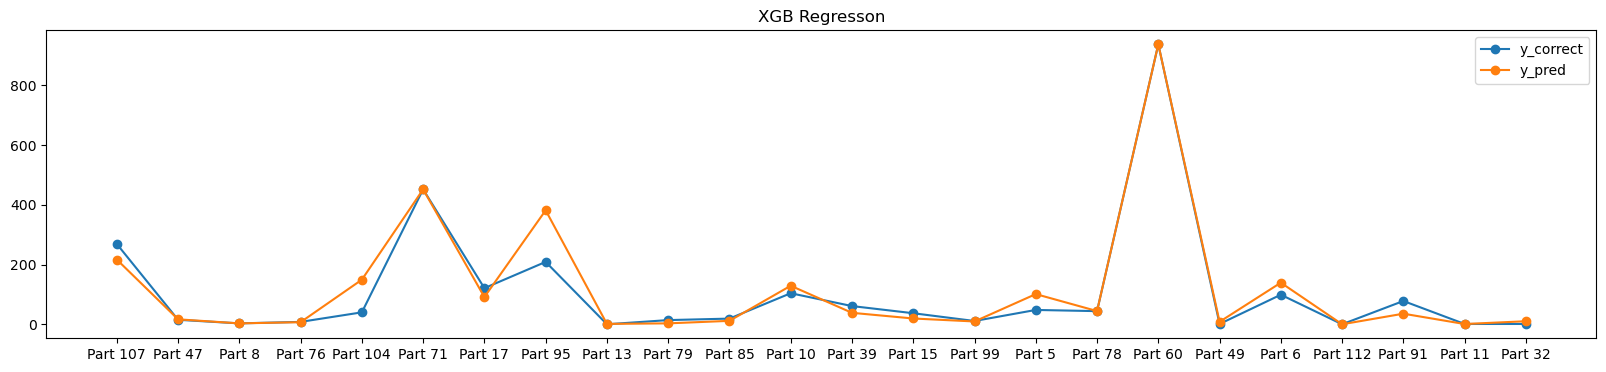

In [10]:
plt.figure(figsize=(20, 4))
plt.plot(y_test, label='y_correct', marker='o')
plt.plot(y_pred, label='y_pred', marker='o')
plt.title('XGB Regresson')
plt.legend()
plt.show()

In [11]:
pred_5 = pd.DataFrame(y_pred)
pred_5.columns = ['2021-11-01']
pred_5.index = y_test.index
pred_5 = pred_5.T
pred_5.index = pd.to_datetime(pred_5.index).date

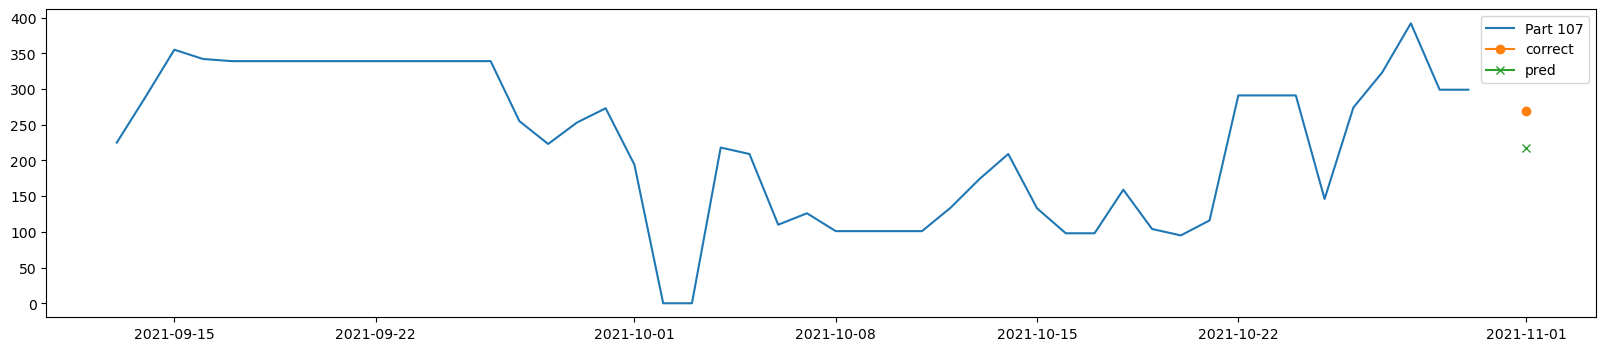

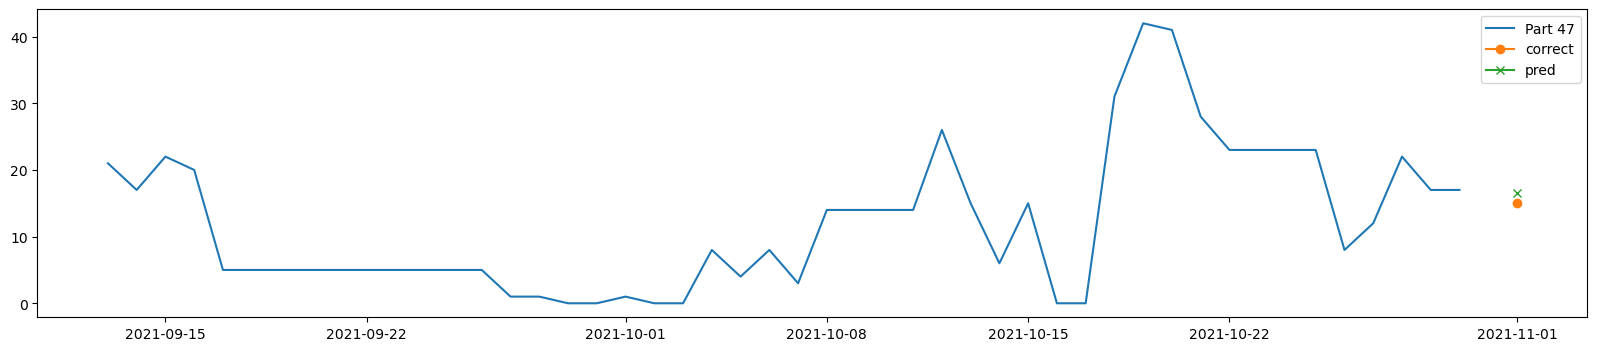

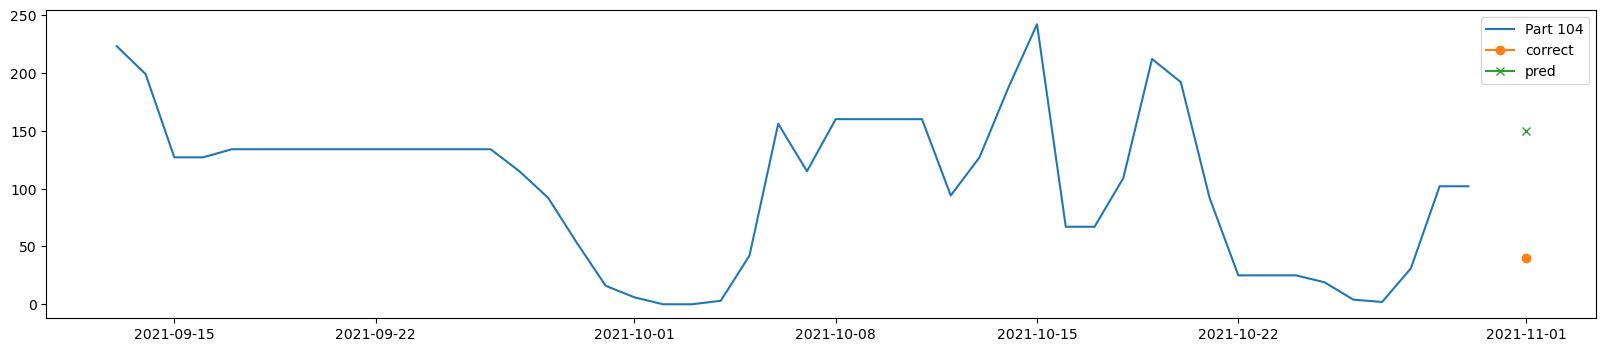

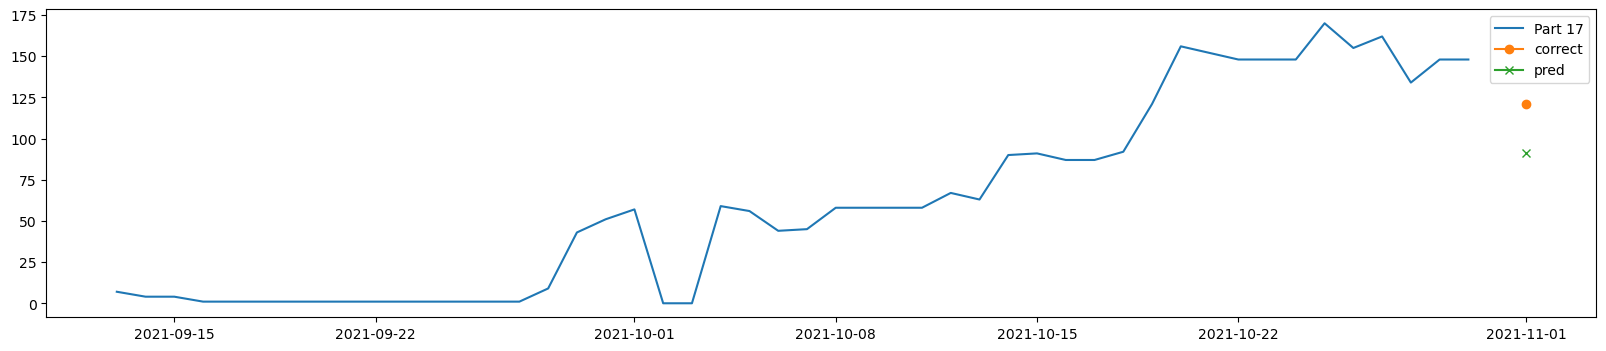

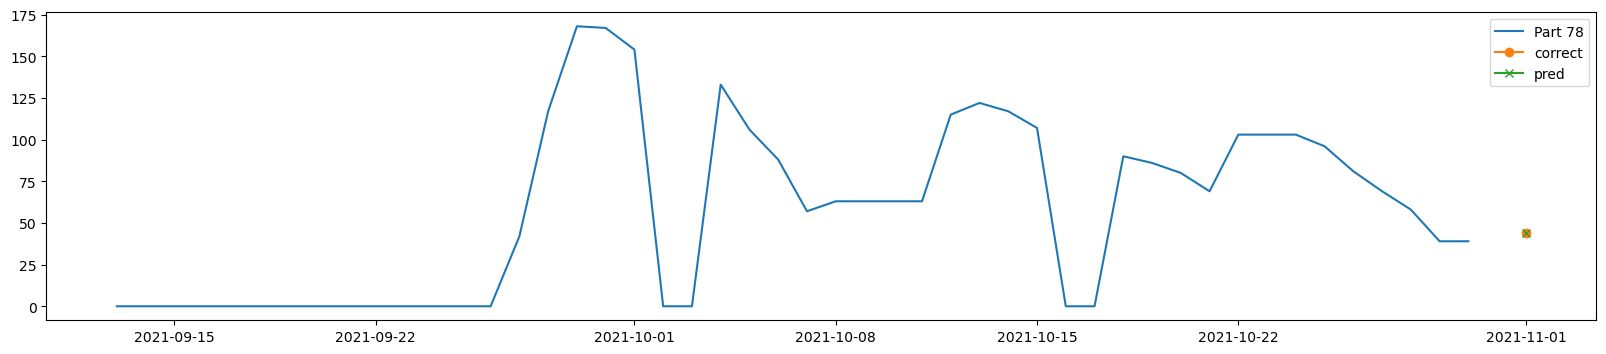

In [12]:
top_5 = ['Part 107', 'Part 47', 'Part 104', 'Part 17', 'Part 78']

for i in top_5:
    plt.figure(figsize=(20, 4))
    plt.plot(X_test.columns, X_test.loc[f'{i}'], label=f'{i}')
    plt.plot(y_test.columns, y_test.loc[f'{i}'], marker='o', label='correct')
    plt.plot(pred_5[f'{i}'], marker='x', label='pred')
    plt.legend()
    plt.show()

### 3-2. Decision Tree Regressor

In [13]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [14]:
# 모델 평가
rmse_d = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
mae_d = metrics.mean_absolute_error(y_test, y_pred)
r2_d = metrics.r2_score(y_test, y_pred)

print("RMSE: %.4f, MAE: %.4f, R-squared: %.4f" % (rmse_d, mae_d, r2_d))

RMSE: 35.4295, MAE: 20.2500, R-squared: 0.9692


In [15]:
# 모델 저장
# path = './model'
# os.makedirs(path, exist_ok=True)
# joblib.dump(model, './model/decision.pkl')

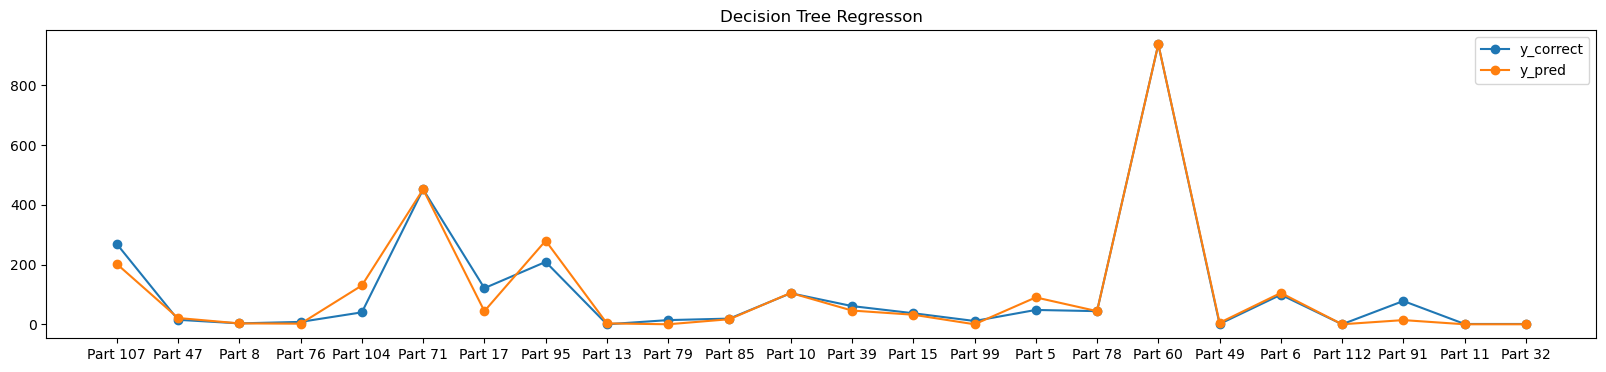

In [16]:
plt.figure(figsize=(20, 4))
plt.plot(y_test, label='y_correct', marker='o')
plt.plot(y_pred, label='y_pred', marker='o')
plt.title('Decision Tree Regresson')
plt.legend()
plt.show()

In [17]:
# 시각화 5개
pred_5 = pd.DataFrame(y_pred)
pred_5.columns = ['2021-11-01']
pred_5.index = y_test.index
pred_5 = pred_5.T
pred_5.index = pd.to_datetime(pred_5.index).date

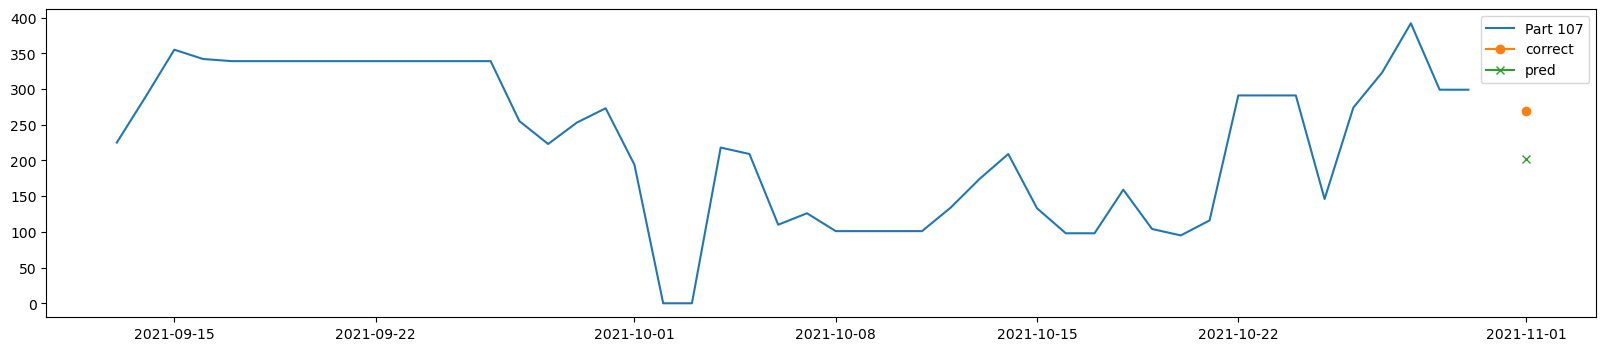

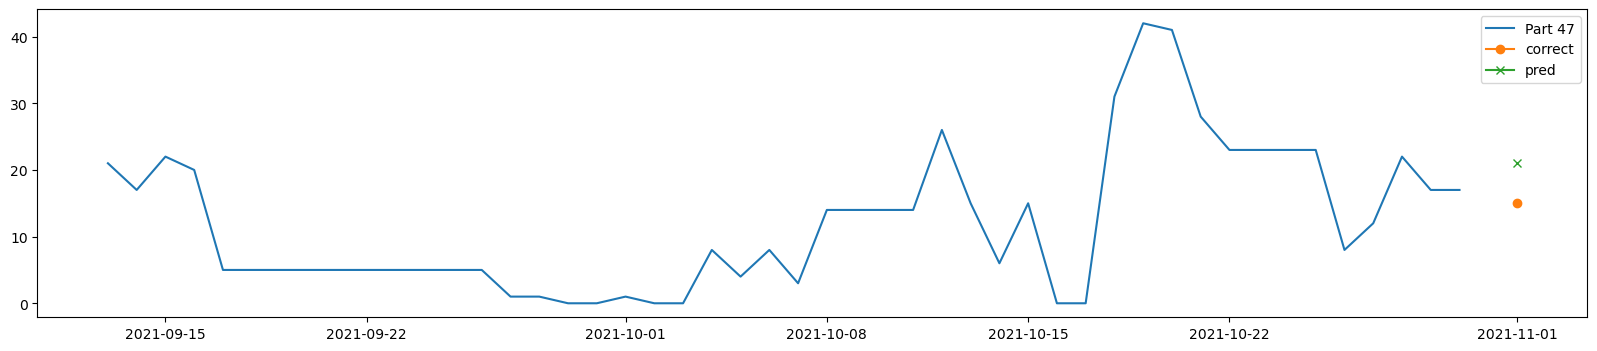

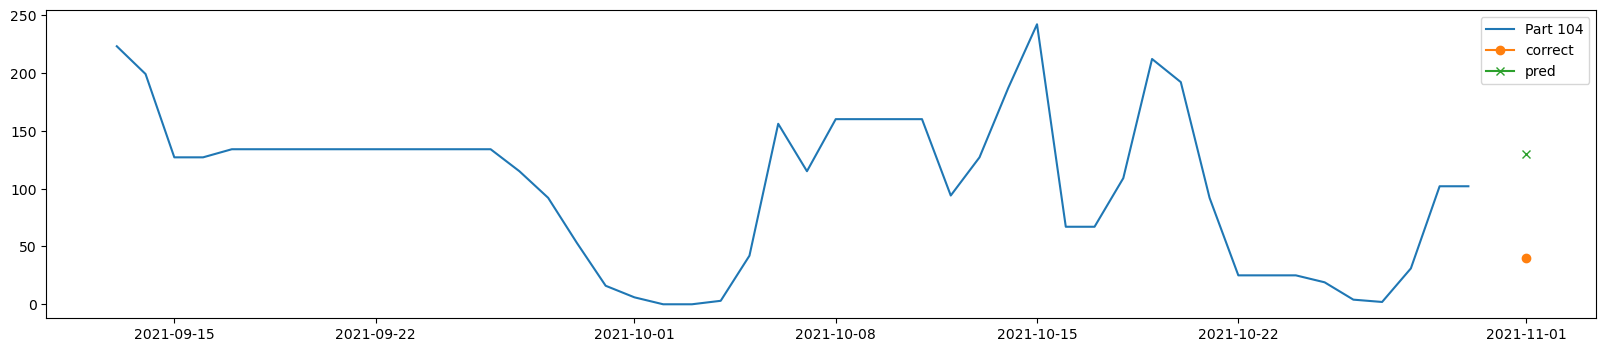

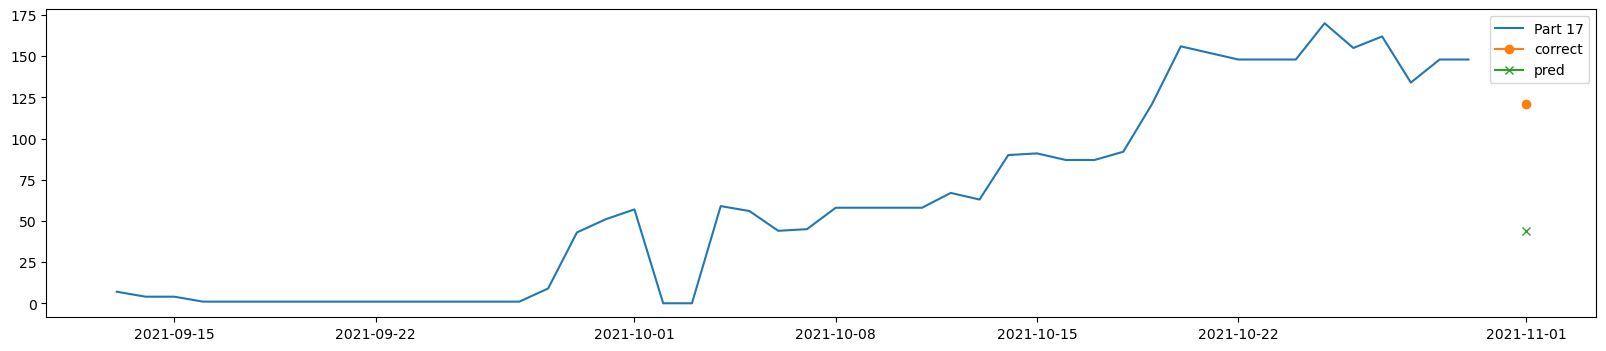

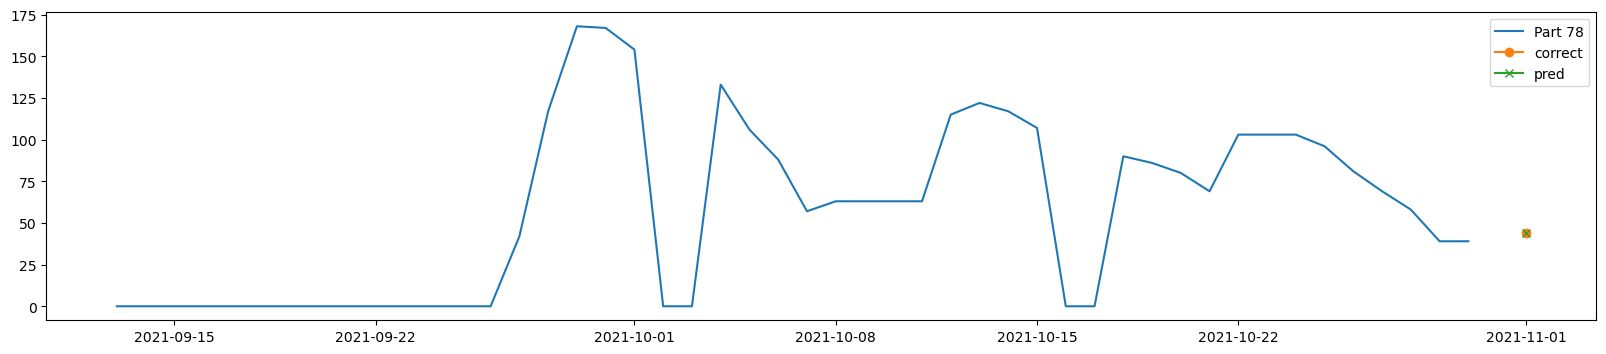

In [18]:
top_5 = ['Part 107', 'Part 47', 'Part 104', 'Part 17', 'Part 78']

for i in top_5:
    plt.figure(figsize=(20, 4))
    plt.plot(X_test.columns, X_test.loc[f'{i}'], label=f'{i}')
    plt.plot(y_test.columns, y_test.loc[f'{i}'], marker='o', label='correct')
    plt.plot(pred_5[f'{i}'], marker='x', label='pred')
    plt.legend()
    plt.show()

### 3-2. Linear Regressor

In [19]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [20]:
# 모델 평가
rmse_l = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
mae_l = metrics.mean_absolute_error(y_test, y_pred)
r2_l = metrics.r2_score(y_test, y_pred)

print("RMSE: %.4f, MAE: %.4f, R-squared: %.4f" % (rmse_l, mae_l, r2_l))

RMSE: 64.0940, MAE: 32.2238, R-squared: 0.8991


In [21]:
# 모델 저장
# path = './model'
# os.makedirs(path, exist_ok=True)
# joblib.dump(model, './model/linear.pkl')

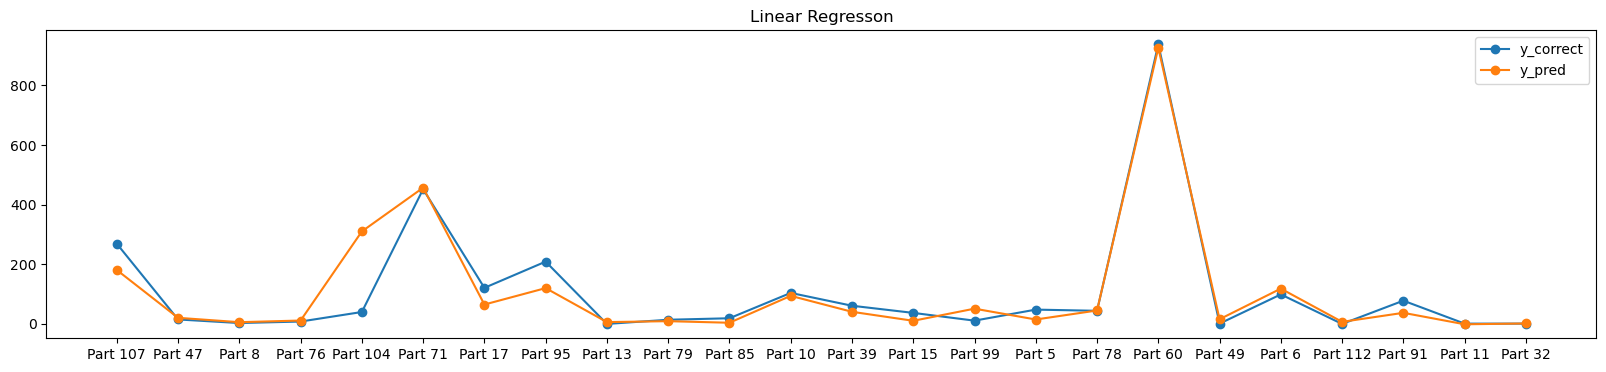

In [27]:
plt.figure(figsize=(20, 4))
plt.plot(y_test, label='y_correct', marker='o')
plt.plot(y_pred, label='y_pred', marker='o')
plt.title('Linear Regresson')
plt.legend()
plt.show()

In [23]:
# 시각화 5개
pred_5 = pd.DataFrame(y_pred)
pred_5.columns = ['2021-11-01']
pred_5.index = y_test.index
pred_5 = pred_5.T
pred_5.index = pd.to_datetime(pred_5.index).date

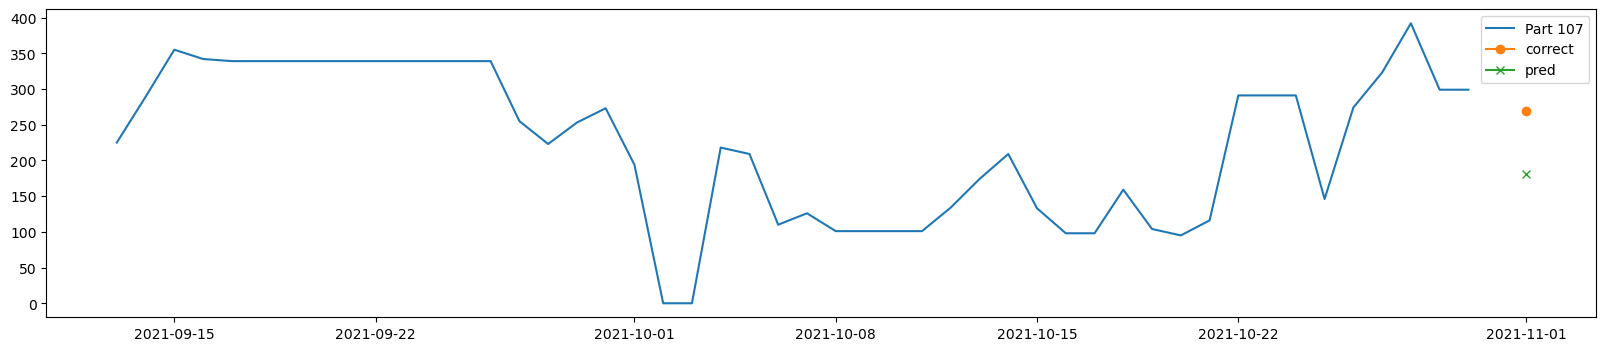

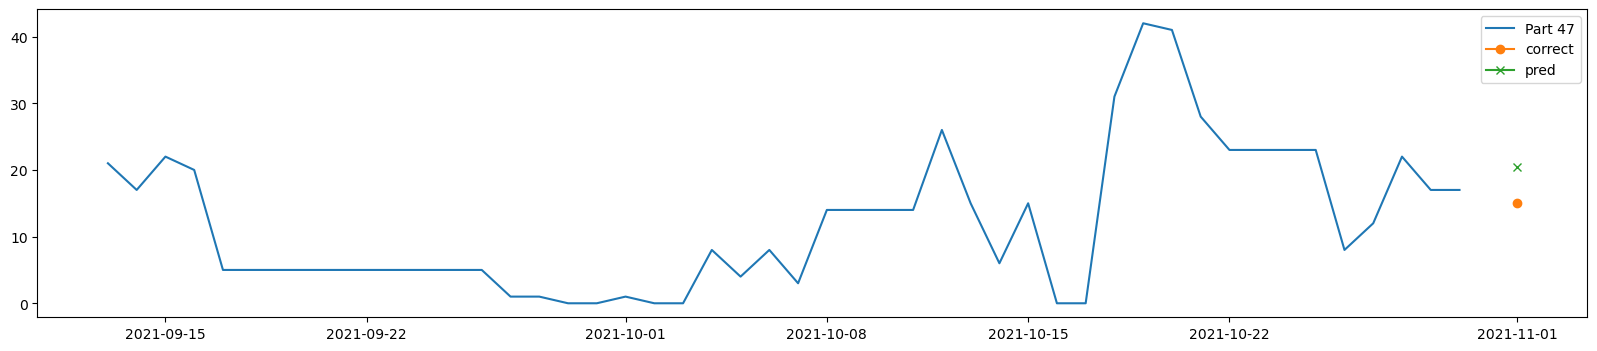

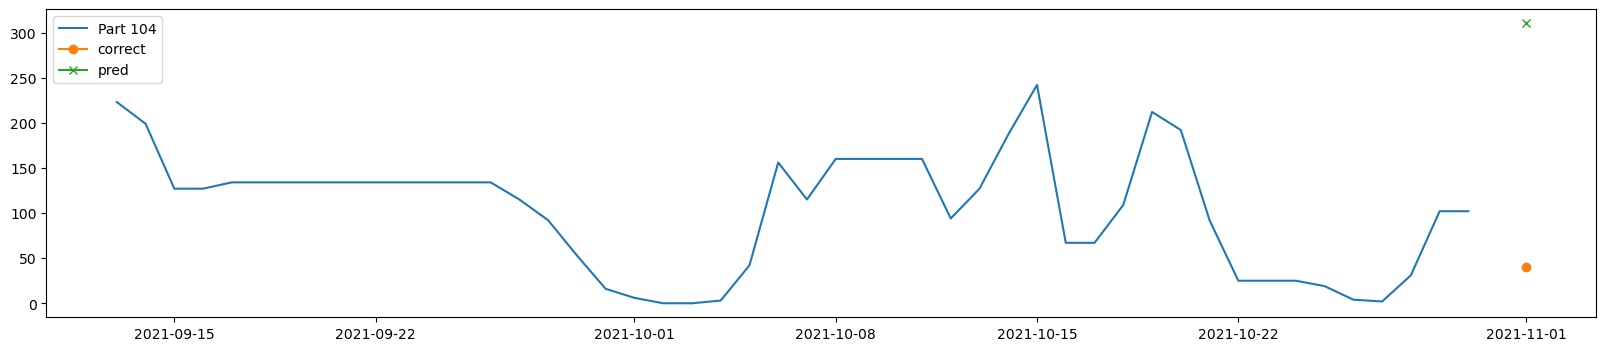

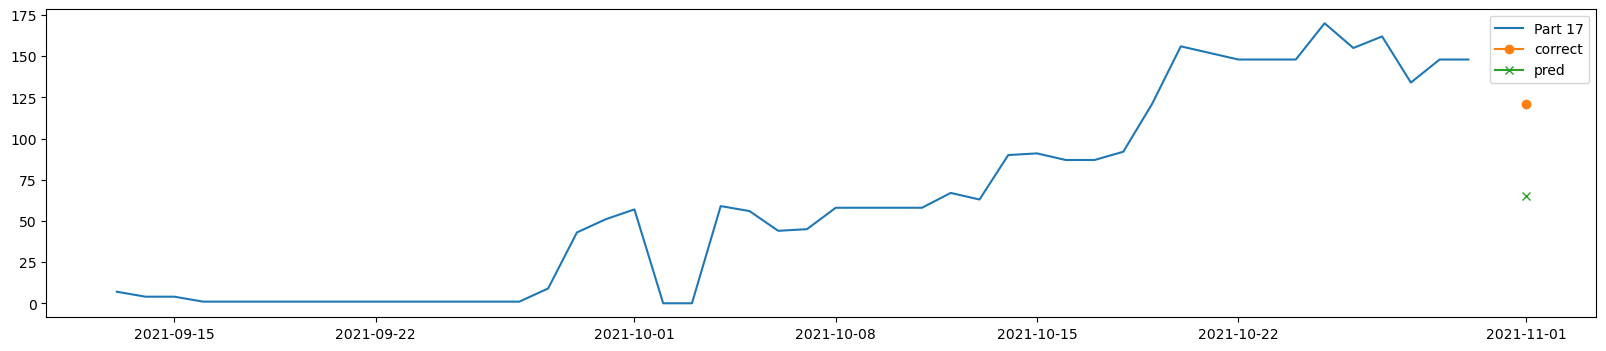

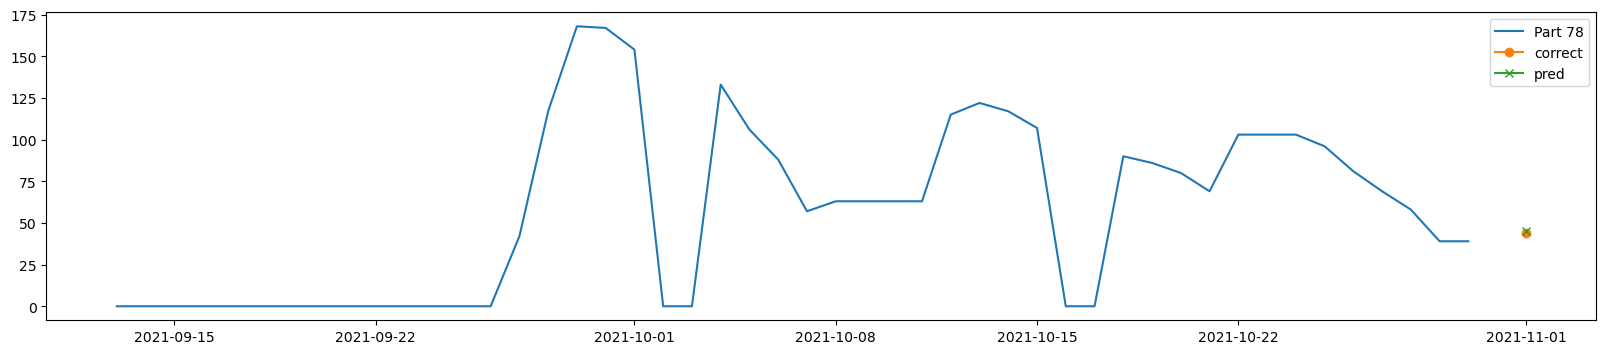

In [24]:
top_5 = ['Part 107', 'Part 47', 'Part 104', 'Part 17', 'Part 78']

for i in top_5:
    plt.figure(figsize=(20, 4))
    plt.plot(X_test.columns, X_test.loc[f'{i}'], label=f'{i}')
    plt.plot(y_test.columns, y_test.loc[f'{i}'], marker='o', label='correct')
    plt.plot(pred_5[f'{i}'], marker='x', label='pred')
    plt.legend()
    plt.show()

## 4. 결과
- Part Number를 인덱스로 활용
- 시간데이터 사용

In [25]:
df_result = pd.DataFrame({'model':['XGB', 'Decision Tree', 'Linear'],
              'RMSE':[rmse_x, rmse_d, rmse_l],
              'MAE':[mae_x, mae_d, mae_l],
              'R-suared':[r2_x, r2_d, r2_l]
             })
df_result

,model,RMSE,MAE,R-suared
0,XGB,47.196723,25.256947,0.945314
1,Decision Tree,35.429507,20.250000,0.969184
2,Linear,64.093961,32.223831,0.899147
